In [30]:
import os
import datetime
import numpy as np
import pandas as pd

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['figure.figsize'] = 12, 4
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
root = os.getcwd() + os.sep

In [5]:
df = pd.read_csv(root + 'train_modified/train_modified.csv', engine='python')

In [8]:
df.shape
df.head()

(87020, 51)

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:
target = 'Disbursed'
IDcol = 'ID'

In [10]:
df[target].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [11]:
import xgboost as xgb

In [13]:
from sklearn import metrics

In [14]:
from sklearn.model_selection import cross_val_score

In [31]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(dtrain[predictors], dtrain['Disbursed'], eval_metric='auc')
    
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]
    
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if dtest is not None:
        dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
        print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))
        
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12, 4))
    plt.ylabel('Feature Importance Score')

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9854
AUC Score (Train): 0.895159


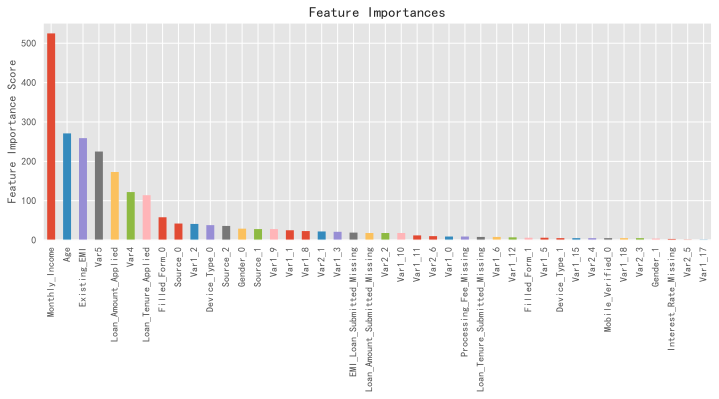

In [32]:
predictors = [x for x in df.columns if x not in [target, IDcol]]
xgb1 = xgb.XGBClassifier(learning_rate=0.1, 
                         n_estimators=1000, 
                         max_depth=5, 
                         min_child_weight=1, 
                         gamma=0, 
                         subsample=0.8, 
                         colsample_bytree=0.8, 
                         objective='binary:logistic', 
                         nthread=4, 
                         scale_pos_weight=1,
                         seed=27)

modelfit(xgb1, df, None, predictors)

In [33]:
from sklearn.model_selection import GridSearchCV

In [36]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df[predictors],df[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [37]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83788, std: 0.00888, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83662, std: 0.00955, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83736, std: 0.00843, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84122, std: 0.00837, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84133, std: 0.00680, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84037, std: 0.00626, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83630, std: 0.00686, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83527, std: 0.00690, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83657, std: 0.00615, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82714, std: 0.00635, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.82677, std: 0.00668, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83054, std: 0.00682, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 3

In [41]:
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(df[predictors],df[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [42]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84093, std: 0.00731, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.84112, std: 0.00743, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.84046, std: 0.00604, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.84137, std: 0.00808, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.84133, std: 0.00680, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84124, std: 0.00575, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.83808, std: 0.00798, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.83740, std: 0.00739, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.83918, std: 0.00603, params: {'max_depth': 6, 'min_child_weight': 4}],
 {'max_depth': 5, 'min_child_weight': 2},
 0.8413736360161839)

In [44]:
param_test2b = {
    'min_child_weight':range(1, 6, 1)
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(df[predictors],df[target])
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84122, std: 0.00837, params: {'min_child_weight': 1},
  mean: 0.84137, std: 0.00808, params: {'min_child_weight': 2},
  mean: 0.84133, std: 0.00680, params: {'min_child_weight': 3},
  mean: 0.84124, std: 0.00575, params: {'min_child_weight': 4},
  mean: 0.84037, std: 0.00626, params: {'min_child_weight': 5}],
 {'min_child_weight': 2},
 0.8413736360161839)

In [46]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df[predictors],df[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.84137, std: 0.00808, params: {'gamma': 0.0},
  mean: 0.84149, std: 0.00818, params: {'gamma': 0.1},
  mean: 0.84184, std: 0.00729, params: {'gamma': 0.2},
  mean: 0.84224, std: 0.00747, params: {'gamma': 0.3},
  mean: 0.84159, std: 0.00793, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.8422418000276434)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9854
AUC Score (Train): 0.890714


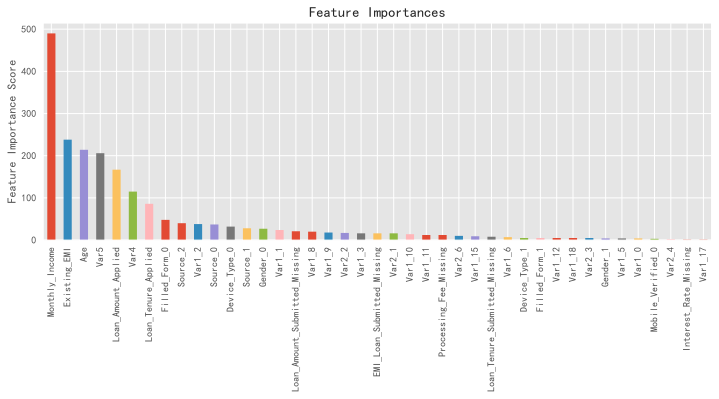

In [49]:
predictors = [x for x in df.columns if x not in [target, IDcol]]
xgb2 = xgb.XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=2,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, df, None, predictors)